# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
from transformers import BertTokenizer
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Set constants

In [2]:
file_path = "610_ps4_training\\610_ps4_training\\trainingT1FD\\cct_train.csv"
model_path = "models\\t1"
random_seed = 42

# Reading Data

In [3]:
data = pd.read_csv(file_path, header=0)

## Find number of columns and rows with NaN entries

In [4]:
print(np.count_nonzero(data.isnull().any().sum()))

0


We see that we have no NaN value which is good

## Splitting data into train, tune and validate

In [5]:
Train, Validate= train_test_split(data, test_size=0.1, random_state=random_seed, stratify=data['is_fraud'])
Train, Tune= train_test_split(Train, test_size=0.1, random_state=random_seed, stratify=Train['is_fraud'])

# resetting index
Train = Train.reset_index(drop=True)
Tune = Tune.reset_index(drop=True)
Validate = Validate.reset_index(drop=True)

# delete data dataframe to save memory
data = data.iloc[0:0]

print("Train data shape = ",Train.shape)
print("Tune data shape = ",Tune.shape)
print("validate data shape = ",Validate.shape)

Train data shape =  (567653, 26)
Tune data shape =  (63073, 26)
validate data shape =  (70081, 26)


We will explore and train on the training data<br>
We will tune on the tuning dataset<br>
We will only look at validate data for model validation

# Exploring Data

## Find Class distribution

In [6]:
print('No Frauds', round(Train['is_fraud'].value_counts()[0]/len(Train['is_fraud']) * 100,4), '% of the dataset')
print('Frauds', round(Train['is_fraud'].value_counts()[1]/len(Train['is_fraud']) * 100,4), '% of the dataset')

No Frauds 99.4893 % of the dataset
Frauds 0.5107 % of the dataset


Classes are heavily biased towards the not fraud case so we have to employ some methods to tackle this issue.

## Get column data types

In [7]:
Train.dtypes

ssn            object
cc_num          int64
first          object
last           object
gender         object
street         object
city           object
state          object
zip             int64
lat           float64
long          float64
city_pop        int64
job            object
dob            object
acct_num        int64
profile        object
trans_num      object
trans_date     object
trans_time     object
unix_time       int64
category       object
amt           float64
merchant       object
merch_lat     float64
merch_long    float64
is_fraud        int64
dtype: object

Our data is a mix of string, date and float values. We need to convert everything to numbers so that we can send our data to our model.

## Get number of unique items

In [8]:
Train.nunique()

ssn              500
cc_num           500
first            257
last             318
gender             2
street           500
city             413
state             48
zip              488
lat              487
long             488
city_pop         427
job              353
dob              496
acct_num         500
profile           12
trans_num     197656
trans_date       712
trans_time     86149
unix_time     562579
category          14
amt            36416
merchant         693
merch_lat     557881
merch_long    563142
is_fraud           2
dtype: int64

### ssn, cc_num, and acct_num might represent the same relationship

Finding unique combinations to confirm theory

In [9]:
Train.groupby(['ssn','cc_num','acct_num']).size()

ssn          cc_num               acct_num    
006-89-0861  4104145964229712525  288157084137    1389
009-02-3453  6011559428434798     942454203201     453
010-61-2168  4903494466574378     701267155766     480
012-48-0983  213118498042533      689915184885     940
013-37-5652  377813767426621      190758885169    1375
                                                  ... 
891-49-6155  2702512868230047     978753281962     926
893-97-2577  4716906181208        617166397458     911
894-70-0589  3534316117240050     254017756402     465
897-37-2345  589556574905         639020125593     476
897-59-9080  3598436241862364     420164855200    2292
Length: 500, dtype: int64

We get 500 so our theory is confirmed

## Get statistics of number type columns

In [10]:
Train.describe()

,cc_num,zip,lat,long,city_pop,acct_num,unix_time,amt,merch_lat,merch_long,is_fraud
count,5.676530e+05,567653.000000,567653.000000,567653.000000,5.676530e+05,5.676530e+05,5.676530e+05,567653.000000,567653.000000,567653.000000,567653.000000
mean,4.175588e+17,51038.086750,37.496106,-91.521203,3.291080e+05,4.960877e+11,1.643728e+09,71.422758,37.493225,-91.522064,0.005107
std,1.294128e+18,29540.071409,5.251695,16.465762,6.149860e+05,2.882812e+11,1.779967e+07,163.217447,5.283381,16.475870,0.071281
min,6.040616e+10,1057.000000,21.299800,-157.875900,4.320000e+02,2.468061e+09,1.611896e+09,1.000000,20.300095,-158.875189,0.000000
25%,1.800216e+14,27530.000000,33.924100,-97.644700,1.764800e+04,2.443508e+11,1.628248e+09,9.250000,33.924144,-97.853799,0.000000
50%,3.542178e+15,49128.000000,38.749600,-86.862200,6.342400e+04,4.712868e+11,1.642466e+09,45.400000,38.572769,-87.036438,0.000000
75%,4.609380e+15,77320.000000,41.091500,-78.898200,2.509750e+05,7.470627e+11,1.659224e+09,82.820000,41.180579,-79.249311,0.000000
max,4.997335e+18,99654.000000,61.592300,-68.020400,2.906700e+06,9.993899e+11,1.673413e+09,14258.810000,62.592198,-67.333254,1.000000


# Preprocess data

## Delete unwanted columns

In [11]:
def del_col(df):
    return df.drop(columns=['ssn','cc_num','unix_time','trans_num'])

## Feature Creation

### Combine first and last to find name

In [12]:
def get_name(df):
    df['name'] = df['first'].astype('str') + ' ' + df['last'].astype('str')
    df = df.drop(columns=['first', 'last'])
    return df

### Get distance between the two (lat,long) pairs

Using Haversine formula to do so

In [13]:
def distance_haversine(df):
    r = 6371 # distance in KM
    p = np.pi/180
    a = 0.5 - np.cos((df['merch_lat']-df['lat'])*p)/2 + np.cos(df['lat']*p) * np.cos(df['merch_lat']*p) * (1-np.cos((df['merch_long']-df['long'])*p))/2
    df['distance'] =  2 * r * np.arcsin(np.sqrt(a))
    df = df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'])
    return df
    


## Deal with Categorical data

We have to deal with gender, state, job, profile, and category. <br>
We do that by one hot encoding these columns

In [14]:
ohe_cols = ['gender', 'state', 'profile', 'category']
def ofe_fit(df):
    # define encoder
    ohe_encoder = OneHotEncoder(variables=ohe_cols)
    
    # fit the encoder
    ohe_encoder.fit(df)
    
    # save encoder
    pickle.dump(ohe_encoder, open(os.path.join(model_path, 'ohe_encoder.pkl'), 'wb'))

def ohe(df):
    # load encoder
    ohe_encoder = pickle.load(open(os.path.join(model_path, 'ohe_encoder.pkl'), 'rb'))
    
    # transform df
    return ohe_encoder.transform(df)

## Deal with DateTime Data

We have to deal with dob, trans_date, trans_time, and unix_time. <br>
Since we already have transaction date and time, we will be directly dropping unix time and it conveys the same info.

### Convert into appropriate formats

dob and trans_date can be split into year, month, and day while trans_time can be split into hrs, mins, and secs

In [15]:
def split_datetime(df):
    df[['dob_year', 'dob_month', 'dob_day']] = df['dob'].str.split('-', expand=True)
    df[['trans_date_year', 'trans_date_month', 'trans_date_day']] = df['trans_date'].str.split('-', expand=True)
    df[['trans_time_hrs', 'trans_time_mins', 'trans_time_secs']] = df['trans_time'].str.split(':', expand=True)
    df = df.drop(columns=['dob', 'trans_date', 'trans_time'])
    return df

### Decompose variables into sin and cosine components

Hour 24 is closer to hour 0 than hour 22 and month 12 is closer to month 0 than month 10. <br>
To deal with the cyclic nature of dates and times, we decompose the variables (except year as it does not follow this property) into sin and cosine components.  

In [16]:
# define varaible to convert and respective possible max values
cyclical_variables = ['dob_month', 'dob_day', 'trans_date_month', 'trans_date_day', 'trans_time_mins', 'trans_time_secs', 'trans_time_hrs']
max_values = {'dob_month':12, 'dob_day':31, 'trans_date_month':12, 'trans_date_day':31,'trans_time_hrs':24, 'trans_time_mins':60, 'trans_time_secs':60}

def fit_cyclic_transform(df):
    # convert columns to numeric format
    df[cyclical_variables] = df[cyclical_variables].astype(float)

    # define transformer
    cyclical = CyclicalFeatures(variables = cyclical_variables, max_values = max_values, drop_original = True)
    
    # fit transformer
    cyclical.fit(df)
    
    # save transformer
    pickle.dump(cyclical, open(os.path.join(model_path, 'cyclical.pkl'), 'wb'))
    
    
def cyclic_transform(df):
    # convert columns to numeric format
    df[cyclical_variables] = df[cyclical_variables].astype(float)

    # load encoder
    cyclical = pickle.load(open(os.path.join(model_path, 'cyclical.pkl'), 'rb'))
    
    # transform df
    return cyclical.transform(df)

## Deal with Text Data

We have to deal with first, last, street, city, and merchant

### Preprocess data

In [17]:
def preprocess_text(text):
    # remove unnecessary characters
    text = text.replace('fraud_','').replace(',', '').replace('.', '')
    # lowercase text
    text = str(text).lower()
    return text

def preprocess_text_in_df(df):
    
    df['name'] = np.vectorize(preprocess_text)(df['name']) 
    df['job'] = np.vectorize(preprocess_text)(df['job']) 
    df['street'] = np.vectorize(preprocess_text)(df['street']) 
    df['merchant'] = np.vectorize(preprocess_text)(df['merchant']) 
    df['city'] = np.vectorize(preprocess_text)(df['city']) 
    return df

### Define and tokenize text data using BertTokenizer

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def find_ids(text, max_len):
    tk = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))
    for x in range(len(tk), max_len):
        tk.append(0)
    
    return tk[:max_len]

def sent_to_ids(df):
    df['name'] = df['name'].apply(find_ids, max_len=5)
    df['job'] = df['job'].apply(find_ids, max_len=10)
    df['street'] = df['street'].apply(find_ids, max_len=15)
    df['merchant'] = df['merchant'].apply(find_ids, max_len=10)
    df['city'] = df['city'].apply(find_ids, max_len=5)
    
    return df

def convert_list_to_cols(df, col_name):
    tdf = df[col_name].to_list()
    tdf = pd.DataFrame(tdf, columns=[str(col_name)+'_'+str(x) for x in range(len(tdf[0]))])
    df = pd.concat([df, tdf], axis=1)
    df = df.drop(columns=[col_name])
    return df

def convert_list_to_cols_multi(df):
    df = convert_list_to_cols(df, 'name')
    df = convert_list_to_cols(df, 'job')
    df = convert_list_to_cols(df, 'street')
    df = convert_list_to_cols(df, 'merchant')
    df = convert_list_to_cols(df, 'city')
    return df

## Convert everything to float and scale values

In [19]:
cols_to_be_normalized = ['zip', 'city_pop', 'amt',
                         'dob_month_sin', 'dob_day_sin', 
                         'trans_date_month_sin', 'trans_date_day_sin', 
                         'trans_time_mins_sin', 'trans_time_secs_sin', 
                         'dob_month_cos', 'dob_day_cos', 
                         'trans_date_month_cos', 'trans_date_day_cos', 
                         'trans_time_mins_cos', 'trans_time_secs_cos',
                         'trans_time_hrs_cos', 'trans_time_hrs_sin']

def fit_scale(df):
    df = df.astype(float)
    scaler = MinMaxScaler()
    scaler.fit(df[cols_to_be_normalized].values)
    # save transformer
    pickle.dump(scaler, open(os.path.join(model_path, 'scaler.pkl'), 'wb'))

def scale(df):
    df = df.astype(float)
    
    # load encoder
    scaler = pickle.load(open(os.path.join(model_path, 'scaler.pkl'), 'rb'))
    
    scaled = scaler.transform(df[cols_to_be_normalized])
    df[cols_to_be_normalized] = pd.DataFrame(scaled, columns=cols_to_be_normalized)
    
    return df

## Create function to call above functions

In [20]:
def preprocess(df, train=False):
    print("     Feature Engineering steps")
    df = del_col(df)
    df = get_name(df)
    df = distance_haversine(df)
    print("     Dealing with Categorical Data")
    if train:
        ofe_fit(df)
    df = ohe(df)
    print("     Dealing with DateTime Date")
    df = split_datetime(df)
    if train:
        fit_cyclic_transform(df)
    df = cyclic_transform(df)
    print("     Dealing with Text Data")
    df = preprocess_text_in_df(df)
    df = sent_to_ids(df)
    df = convert_list_to_cols_multi(df)
    print("     Normalizing Data")
    if train:
        fit_scale(df)
    df = scale(df)
    df = df.astype(float)
    print("     Done")
    return df

## Apply Preprocessing

Please be patient. Dealing with Text Data step can take some time

In [21]:
print("Prepping Training Dataset")
Train = preprocess(Train, train=True)
print("Prepping Tuning Dataset")
Tune = preprocess(Tune)
print("Prepping Validation Dataset")
Validate = preprocess(Validate)

Prepping Training Dataset
     Feature Engineering steps
     Dealing with Categorical Data
     Dealing with DateTime Date
     Dealing with Text Data
     Normalizing Data
     Done
Prepping Tuning Dataset
     Feature Engineering steps
     Dealing with Categorical Data
     Dealing with DateTime Date
     Dealing with Text Data
     Normalizing Data
     Done
Prepping Validation Dataset
     Feature Engineering steps
     Dealing with Categorical Data
     Dealing with DateTime Date
     Dealing with Text Data
     Normalizing Data
     Done


# Using XGBoost

## define f1 error for evaluation

In [22]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred), average='macro')
    return 'f1_err', err

## Define Parameters 

In [23]:
# Define hyperparameters
params = {'device' : 'cuda',
          'objective' : 'binary:logistic',
          'seed' : random_seed,
          'sampling_method' : 'gradient_based'}

## Creating XGB DMatrix

In [24]:
dtrain = xgb.DMatrix(Train.drop(columns=['is_fraud']), Train['is_fraud'], missing=0.0)
Train = Train.iloc[0:0] # resetting it to save memory

dtune = xgb.DMatrix(Tune.drop(columns=['is_fraud']), Tune['is_fraud'], missing=0.0)
Tune = Tune.iloc[0:0] # resetting it to save memory

dvalidate = xgb.DMatrix(Validate.drop(columns=['is_fraud']), Validate['is_fraud'], missing=0.0)

## Fit Model

In [25]:
# define evaluation set
evals = [(dtrain, "train"), (dtune, "validation")]

# fit model
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=10000,
                  evals=evals,
                  early_stopping_rounds=50,
                  custom_metric = f1_eval)

# save model
pickle.dump(model, open(os.path.join(model_path, 'model.pkl'), 'wb'))

[0]	train-logloss:0.10113	train-f1_err:0.22046	validation-logloss:0.10132	validation-f1_err:0.22426
[1]	train-logloss:0.07570	train-f1_err:0.18659	validation-logloss:0.07601	validation-f1_err:0.19286
[2]	train-logloss:0.05760	train-f1_err:0.17005	validation-logloss:0.05797	validation-f1_err:0.16868
[3]	train-logloss:0.04433	train-f1_err:0.15371	validation-logloss:0.04477	validation-f1_err:0.15270
[4]	train-logloss:0.03469	train-f1_err:0.14569	validation-logloss:0.03512	validation-f1_err:0.14246
[5]	train-logloss:0.02772	train-f1_err:0.13271	validation-logloss:0.02824	validation-f1_err:0.13414
[6]	train-logloss:0.02263	train-f1_err:0.12783	validation-logloss:0.02323	validation-f1_err:0.13536
[7]	train-logloss:0.01879	train-f1_err:0.12550	validation-logloss:0.01941	validation-f1_err:0.13273
[8]	train-logloss:0.01600	train-f1_err:0.12078	validation-logloss:0.01667	validation-f1_err:0.12671
[9]	train-logloss:0.01366	train-f1_err:0.11573	validation-logloss:0.01432	validation-f1_err:0.12552


[82]	train-logloss:0.00099	train-f1_err:0.00900	validation-logloss:0.00417	validation-f1_err:0.06125
[83]	train-logloss:0.00097	train-f1_err:0.00882	validation-logloss:0.00417	validation-f1_err:0.06125
[84]	train-logloss:0.00096	train-f1_err:0.00855	validation-logloss:0.00417	validation-f1_err:0.06125
[85]	train-logloss:0.00094	train-f1_err:0.00828	validation-logloss:0.00417	validation-f1_err:0.06202
[86]	train-logloss:0.00093	train-f1_err:0.00792	validation-logloss:0.00418	validation-f1_err:0.06300
[87]	train-logloss:0.00091	train-f1_err:0.00765	validation-logloss:0.00419	validation-f1_err:0.06202
[88]	train-logloss:0.00088	train-f1_err:0.00721	validation-logloss:0.00419	validation-f1_err:0.06202
[89]	train-logloss:0.00086	train-f1_err:0.00685	validation-logloss:0.00418	validation-f1_err:0.06104
[90]	train-logloss:0.00084	train-f1_err:0.00649	validation-logloss:0.00419	validation-f1_err:0.06028
[91]	train-logloss:0.00082	train-f1_err:0.00623	validation-logloss:0.00420	validation-f1_er

[163]	train-logloss:0.00022	train-f1_err:0.00000	validation-logloss:0.00419	validation-f1_err:0.05428
[164]	train-logloss:0.00021	train-f1_err:0.00000	validation-logloss:0.00418	validation-f1_err:0.05428
[165]	train-logloss:0.00021	train-f1_err:0.00000	validation-logloss:0.00414	validation-f1_err:0.05428
[166]	train-logloss:0.00020	train-f1_err:0.00000	validation-logloss:0.00415	validation-f1_err:0.05333
[167]	train-logloss:0.00020	train-f1_err:0.00000	validation-logloss:0.00415	validation-f1_err:0.05256
[168]	train-logloss:0.00020	train-f1_err:0.00000	validation-logloss:0.00417	validation-f1_err:0.05447
[169]	train-logloss:0.00019	train-f1_err:0.00000	validation-logloss:0.00415	validation-f1_err:0.05447
[170]	train-logloss:0.00019	train-f1_err:0.00000	validation-logloss:0.00414	validation-f1_err:0.05351
[171]	train-logloss:0.00019	train-f1_err:0.00000	validation-logloss:0.00414	validation-f1_err:0.05351
[172]	train-logloss:0.00018	train-f1_err:0.00000	validation-logloss:0.00416	valida

# Get final score on validation set

Classification report
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     69723
    Is Fraud       0.99      0.85      0.92       358

    accuracy                           1.00     70081
   macro avg       1.00      0.93      0.96     70081
weighted avg       1.00      1.00      1.00     70081


Macro F1
0.9584494796853635



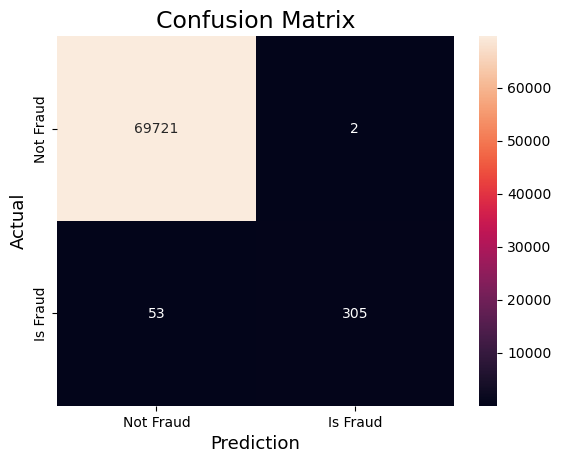

In [26]:
# load model
model = pickle.load(open(os.path.join(model_path, 'model.pkl'), 'rb'))
    
preds = model.predict(dvalidate)

print("Classification report")
print(classification_report(Validate['is_fraud'], np.round(preds), labels=range(0,2), target_names=["Not Fraud", "Is Fraud"]))
print()
print("Macro F1")
print(f1_score(Validate['is_fraud'], np.round(preds), average='macro'))
print()
cm = confusion_matrix(Validate['is_fraud'],np.round(preds))
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=["Not Fraud", "Is Fraud"],
            yticklabels=["Not Fraud", "Is Fraud"])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()